<div style="text-align: right">Kane Toh, 09/04/2020 </div> 

[Gillespie code](https://github.com/aristoteleo/dynamo-release/blob/master/dynamo/simulation/gillespie_utils.py) 

Algorithm for implementation of gillespie simulation adapted from Xiaojie Qiu and Yan Zhang



[Gillespie plots](http://be150.caltech.edu/2019/handouts/12_stochastic_simulation.html)

 Plotting of gillespie simulation adapted from Justin Bois's jupyter notebook



# Architecture of the *Cis*- regulatory function:

**Hill-equation**:

$$ \frac{dx}{dt} = (\alpha_{1} + \frac{max_{1}x^n}{a^n + x^n})(\frac{b^n}{b^n + y^n}) - \lambda_{1}x_{1} $$

$$ \frac{dy}{dt} = (\alpha_{2} + \frac{max_{2}y^n}{c^n + y^n})(\frac{d^n}{d^n + x^n}) - \lambda_{2}x_{2} $$

where:
- `x` and `y` are the concentrations of the 2 proteins X and Y.
- $\alpha_{1}$ and $\alpha_{2}$ are the rates of production of gene X/Y, in absence of activation by X/Y.
- `n` is the Hill coefficient.
- `a` and `c` are the concentrations for the half-maximal activation by genes X/Y on genes X/Y. The inverses, $\frac{1}{a}$   and $\frac{1}{c}$ represents the efficiency of the activator in other equivalent formulations (see Goutsias and Kim, 2004) 
- `b` and `d` are the concentrations for the half-maximal repression by genes X/Y on genes Y/X. The inverses, $\frac{1}{b}$
and $\frac{1}{d}$ represents the efficiency of the repressor in other equivalent formulations.
- $max_{1}$ and $max_{2}$ are the maximum rates of protein production by activators X / Y. To see this, 
  take $\displaystyle\lim_{a \to 0} \frac{max_{1}x^n}{a^n + x^n}$
 

Equation is modified from Verd et al., (2014) and Jaeger et al., (2012), with
the exact form seen in Laslo et al.,(2006) - see supplementary equation S1.
In the Verd and Jaeger formulation, the maximum rate of protein production 
set by the activator is implicitly set to 1 - this has been adjusted in the stochastic simulation
to convert concentrations (continuous) to molecule counts (discrete).

**General assumptions in Michaelis-like formulations**
1.  Extreme cooperativity. (Hill, 1985, pg 65)
2.  AND regulatory logic. 
3.  Polymerase is present in excess.
4.  Activator and repressor act at independent sites.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import seaborn as sns
sns.set(style='whitegrid', context='notebook', 
        palette='muted', rc={'axes.labelsize': 16})

In [2]:
 def protein_production (x, alpha1, alpha2, a, c, b, d, max1, max2, tolerance = 1e-8): 
    """Return the cis-regulatory function i.e. the protein production rate.
    
    Keyword arguments: Definition and (units)
    x      -- input numpy array of concentration of 2 gene products X and Y. (concentration)
    alpha1 -- Rate of production of gene X, in absence of activation by X. (concentration/time)
    alpha2 -- Rate of production of gene Y, in absence of activation by Y. (concentration/time)
    a      -- Concentration for half-maximal activation by gene X. (concentration)
    c      -- Concentration for half-maximal activation by gene Y.(concentration)
    b      -- Concentration for half-maximal repression by gene Y.(concentration)
    d      -- Concentration for half-maximal repression by gene Y. (concentration)
    max1   -- Maximum rate of protein production caused by activator X.(concentration/time)
    max2   -- Maximum rate of protein production caused by activator Y.(concentration/time)"""
  
    xp,yp = x[0],x[1]
    xdot = (alpha1 +  max1*(xp**4 / (a**4+xp**4 )))*(b**4/ (b**4 +yp**4))
    ydot = (alpha2 + max2*(yp**4 / (c**4+yp**4 )))*(d**4/ (d**4 + xp**4)) 
    f = np.array([xdot, ydot])
    
    for conc in f:
        if conc < tolerance:
            conc = 0
    return f

In [3]:
def decay (x, lambda1, lambda2, tolerance = 1e-8):
    """Return the decay rate.
    
    Keyword arguments:
    lambda1-- decay rate of protein product X. (concentration/time)
    lambda2-- decay rate of protein product Y. (concentration/time) """
    
    xd,yd = x[0],x[1]
    xdot = lambda1*xd
    ydot = lambda2*yd
    f = np.array([xdot, ydot])
   
    for conc in f:
        if conc < tolerance:
            conc = 0
        
    return f
    

In [4]:
def deterministic_term (protein_production, decay):
    """Return the deterministic/mean function of the chemical langevin equation (CLE).
    
    This is equivalent to the Reaction Rate Equation determined from the law of mass action in 
    classic chemical kinetics""" 
  
    xp,yp,xd,yd = protein_production[0] , protein_production[1], decay[0], decay[1]
    xdot = xp-xd
    ydot = yp-yd
    f = np.array([xdot, ydot])
    return f

# The Chemical langevin equation (CLE) approximation

## Background on stochastic differential equations (SDE)

A stochastic differential equation (SDE) has the form:

$ d\mathit{x} = \mathit{\mu(x,t)dt} + \mathit{\sigma(x,t)dW} $

where:

- $\mu(x,t)$ is the **drift** coefficient / **deterministic** term
- $\sigma(x,t)$ is the **diffusion** coefficient / **diffusion** term 
- `dW` is the derivative of a **Brownian Motion**. Specifically, this derivative is called **white noise**, and is a sequence of gaussian-distributed random variables.

[Interpretation](https://en.wikipedia.org/wiki/Stochastic_differential_equation#Background)
A heuristic to interpret the SDE is that, for a small interval $\delta$, the process $X_{t}$ changes by a value which is normally distributed with mean $\mu(x,t)\delta $ and variance $\sigma^{2}(x,t)\delta $. 

## Connection with GRN modelling

SDEs are relevant to modelling  GRN dynamics from the observation that gene regulation can be treated as a **continuous-time, discrete state Markov process / Markov jump process**. This treatment has two salient points:

1. Gene regulation is a discrete state stochastic process. This is in contrast to traditional approaches that model dynamical systems with ordinary differential equations, where the concentration of reacting species evolves in a continuous and discrete fashion. It is an obvious truth that molecular entities change in discrete steps and that chemical reactions are inherently probabilistic. The important question here is whether this discretisation can be replaced with the aforementioned continuous approximation. The validity of the approximation depends on the  number of molecules. For numbers significantly smaller than Avogadro's constant, a stochastic approach that takes molecular fluctuations into account becomes a more accurate description. In this scenario, fluctuations should not be simply 'averaged away' as they can lead to interesting and important behaviours that differ quantitatively and qualitatively from the deterministic approximation. Indeed, in the context of gene reguation, this is particularly relevant with the biological observation that transcription factors of multiple lineages are expressed at low levels in progenitors to prime them towards their destination fates. Intriguing phenomena that can arise when stochastic fluctuations are not trivial include stochastic focusing `(Paulsson et al., 2000)`, the erasure of a stable fixed point `(Lee and Lee, 2018)` and stochastic state switching `(Arkin et al., 1998)`.

2. The stochastic process is markovian. This is particularly attractive because of the mathematical tractability of markovian analyses and the theoretical advances in numerical simulation of markovian processes. For this reason, we will stick to the traditional markovian treatment. Recently however, there has been an increasing switch towards a non-markovian treatment and this has been examined further in `Zhang and Zhou., (2019)`.  


>A stochastic process is a collection of random variables, which we will define by the following set of $\mathit S$ - valued random variables: $ \{X_{i}(t) | t\in T, i\in \Omega, X_{i}(t)\in S\}$ where we take `T` to be time, $\Omega$ as the index set, and `S` as the state space. 
Then, a first-order Markov process is a special category of stochastic processes, where the probability of a state being attained at time $\mathit t$ depends only on the previous state, and not on the entire past history of the system. In other words, the stochastic process is **memoryless**, fulfilling the Markov property:$ P(X(t+dt) = x | {X(t) = x(t) | t \in [0,t]}) = \\ P(X(t+dt) = x | {X(t) = x(t)}), \quad \forall t \in [0,\infty] , x \in \mathit S $ 


## Connection between SDEs and the CLE approximation

The Chemical Langevin Equation (CLE) is simply an SDE, where $\mathit{\mu(x,t)dt}$ and $\mathit{\sigma(x,t)dW}$ matches the mean and standard deviation of the diffusion/langevin approximation to the birth-death process `(Pakdaman et al., 2010)`.

Essentially, we can reformulate the problem as a birth-death process with immigration rate $x_{p}$ and death rate $\delta$ and the random variable $X$ takes the state $x$ at time $t$. Then the state transition probabilities are:

$\rm P(X_{t+dt} = x-1) = x\delta \rm d \mathit t \\ P(X_{t+dt} = x+1) = x_{p} \rm d \mathit t\\ P(X_{t+dt} = x)   = 1 - x\delta \rm d \mathit t - x_{p} \rm d \mathit t$

Let $\rm d \mathit X_{t}$ be the increment of the process. Then, its
- expectation : 
$\mathbb{E}(\rm d \mathit X_{t}) = (x_{p} - x\delta)\rm d \mathit X_{t}$ 
- variance : $\mathbb{E}[(\rm d \mathit X_{t})^2] - [\mathbb{E}(\rm d \mathit X_{t})]^2$ = $(x_{p} + x\delta)\rm d \mathit X_{t}$ as $(\rm d \mathit t)^2$ term is negligibly small.

In [5]:
# Parameters in deterministic term
alpha1 = 0.1
alpha2 = 0.1
a = 0.5 
c = 0.5
b = 0.4
d = 0.4
max1 = 1
max2 = 1
lambda1 = 1.25
lambda2 = 1.25

# Parameters in stochastic term
#constant_noise = 0.10
dt = .001  # Time step.
T = 100  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0., T, n)  # Vector of times.
omega = 1000 #Volume parameter. This parameter appears again in the Gillespie simulation to convert concentrations to molecules.
sqrtdt =  np.sqrt(dt/omega) 

## Euler-Marayama method to simulate the CLE

The numerical scheme is:

$ x_{n+1}  = x_{n} + \rm d\mathit{x} = x_{n} + \mathit{a(x,t)dt} + \mathit{b(x,t)} \sqrt{\mathit{dt}} \zeta \qquad \zeta \sim N(0,1) $


In [6]:
# Vector containing successive values of the trajectory for both genes
n_traj = 5
x = np.zeros((n_traj,2,n))
x_init = 0.7
y_init = 0.2
# Initial condition 
x[:,:,0]= [x_init,y_init]

tolerance = 1e-8

# Euler-Marayama method
for k in range(n_traj):
    print('Iteration %d/%d finished'% (k+1, n_traj))
    for i in range(n - 1):
        pp = protein_production([x[k][0][i], x[k][1][i]],alpha1,alpha2,a,c,b,d, max1, max2)
        de = decay([x[k][0][i], x[k][1][i]],lambda1,lambda2)
        detT = deterministic_term(pp,de)
        stochastic_term = np.array([np.sqrt(pp[0] + de[0]), np.sqrt(pp[1] + de[1])])
        x[k][0][i + 1] = x[k][0][i] + dt * detT[0] + stochastic_term[0] * sqrtdt * np.random.randn() #Chemical langevin equation
        x[k][1][i + 1] = x[k][1][i] + dt * detT[1] + stochastic_term[1] * sqrtdt * np.random.randn()

        # Tolerance - setting small values and negative values to 0 to account for negative values from the standard normal
        if(x[k][0][i + 1] < tolerance):
            x[k][0][i + 1] = 0
        elif(x[k][1][i + 1] < tolerance):
            x[k][1][i + 1] = 0


Iteration 1/5 finished
Iteration 2/5 finished
Iteration 3/5 finished
Iteration 4/5 finished
Iteration 5/5 finished


Text(0.5, 1.0, 'Sample path of gene Y')

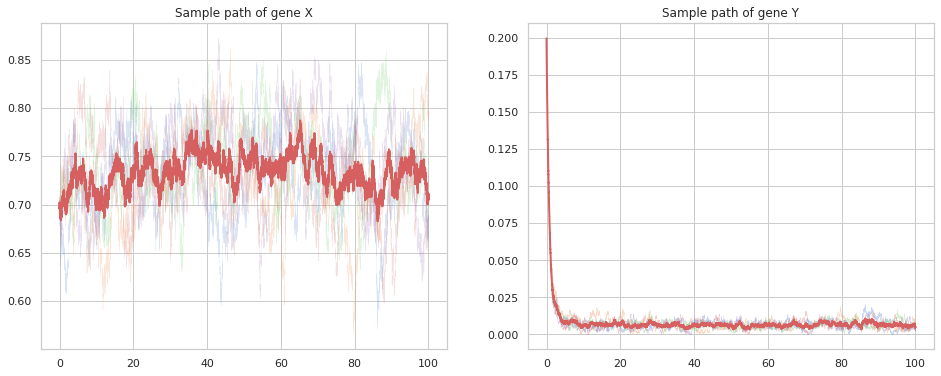

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
ax0, ax1 = axes.flatten()

# Plot gene X trajectories
for i in range(n_traj):
    ax0.plot(t, x[i,0,:], '-', lw=0.3, alpha=0.2, 
               color=sns.color_palette()[i])

# Plot gene X mean
ax0.plot(t, x[:,0,:].mean(axis=0), '-', lw=2, 
           color=sns.color_palette()[3])
ax0.set_title("Sample path of gene X")

# Plot gene X trajectories
for i in range(n_traj):
    ax1.plot(t, x[i,1,:], '-', lw=0.3, alpha=0.3, 
               color=sns.color_palette()[i])

# Plot gene X mean
ax1.plot(t, x[:,1,:].mean(axis=0), '-', lw=2, 
           color=sns.color_palette()[3])
ax1.set_title("Sample path of gene Y")

## Exact realisation of the stochastic process with the Gillespie algorithm (direct method)

In [9]:

def directMethod(
    prop_fcn, update_fcn, tspan, X0, record_skip_steps=0, record_max_length=1e5
):
    # Initialise array to hold the concentration and time values, with the appropriate dimensions.
    retX = np.zeros((len(X0), int(record_max_length)), np.float64)
    retT = np.zeros(int(record_max_length), np.float64)
    
    # Initialise initial concentration and starting time  
    X = X0.flatten() 
    t = tspan[0]
    retX[:, 0] = X 
    retT[0] = t
    count = 0 #To keep track of the number of loops
    
    while (t <= tspan[-1]) & (count < record_max_length - 1):
        count += 1
        # 1) Evaluate/update the propensity function for each reaction
        a = prop_fcn(X)
        a0 = sum(a)
        
        # 2) Obtain 2 uniformly distributed random numbers
        r = np.random.rand(2)
        
        # 2.1) Obtain the time to the next reaction, tau
        tau = -np.log(r[0]) / a0
        
        # 2.2) Obtain the reaction type that fires.
        #Search sorted function: For a given ORDERED sequence of numbers, give position which the given value 
        #needs to be inserted into in order to maintain order.
        mu = np.cumsum(a).searchsorted(r[1] * a0)
        
        # Update the time and concentration vectors.
        t += tau
        X = update_fcn(X, mu)
        retT[count] = t
        retX[:, count] = X

    # In the event the loop terminates as the max time is reached, we want to truncate the arrays so we don't hold
    # all the zeros in the lists in memory.
    
    retT = retT[: count + 1]
    retX = retX[:, : count + 1]

    return retT, retX


def prop_hill(X,  alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega):
    # species
    x = X[0]
    y = X[1]
    
    # propensities
    prop = np.zeros(4)
    prop[0],prop[2] = omega * protein_production (X, alpha1, alpha2, a, c, b, d, max1, max2, tolerance = 1e-8)
    prop[1],prop[3] = decay(X, lambda1, lambda2, tolerance = 1e-8)

    return prop

def simulate_Gillespie(X0, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega, t_span, n_traj, seed_no, report=True):
    # species
    x = 0
    y = 1
    n_species= 2

    # stoichiometry matrix
    stoich = np.zeros((4, n_species))
    stoich[0, x] = 1  # null -> x
    stoich[1, x] = -1  # x -> null
    stoich[2, y] = 1  # null -> y
    stoich[3, y] = -1  # y -> null
    
    # Update function: take concentration vector and update it by adding corresponding stoichometric reaction row.
    update_func = lambda X, mu: X + stoich[mu, :]

    # Initialise list to hold n_traj numbers of concentration trajectories and time steps.
    trajs_T = [[]] * n_traj
    trajs_C = [[]] * n_traj
    
    np.random.seed(seed_no)

    for i in range(n_traj):
        T, X = directMethod(
            lambda X: prop_hill(X, alpha1, alpha2, a, c, b, d, max1, max2, lambda1, lambda2, omega),
            update_func,
            t_span,
            X0[i],
        )
        trajs_T[i] = T
        trajs_C[i] = X
        if report:
            print("Iteration %d/%d finished." % (i + 1, n_traj), end="\r")
    return np.array(trajs_T), np.array(trajs_C)


In [10]:
n_traj = 5

para_gillespie = {
"n_traj" : n_traj,  # Number of trajectories to simulate in the simulate_gillespie function
"X0" : np.array([[x_init*omega, y_init*omega]]*n_traj),
"alpha1" : 0.1 * omega,
"alpha2" : 0.1 * omega,
"a" :0.5 * omega,
"c" : 0.5 * omega,
"b" : 0.4 * omega,
"d" : 0.4 * omega,
"max1" : 1 * omega,
"max2" : 1 * omega,
"lambda1" : 1.25 * omega,
"lambda2" : 1.25 * omega,
"omega":omega,
"t_span" : [0,5], #Total duration of gillespie simulation
"seed_no":2020,
"report" :True
}

In [11]:
trajs_T, trajs_C = simulate_Gillespie(**para_gillespie)

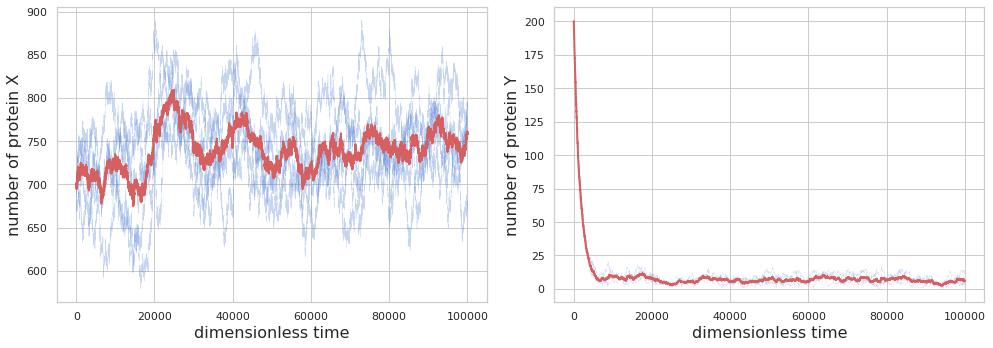

In [13]:
time_steps = np.arange(trajs_T.shape[1])

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot gene X trajectories
for i in range(n_traj):
    ax[0].plot(time_steps, trajs_C[i,0,:], '-', lw=0.3, alpha=0.3, 
               color=sns.color_palette()[0])

# Plot gene X mean
ax[0].plot(time_steps, trajs_C[:,0,:].mean(axis=0), '-', lw=2, 
           color=sns.color_palette()[3])

# Plot gene Y trajectories
for i in range(n_traj):
    ax[1].plot(time_steps, trajs_C[i,1,:], 'k-', lw=0.3, alpha=0.3,
               color=sns.color_palette()[0])

# Plot gene Y mean
ax[1].plot(time_steps, trajs_C[:,1,:].mean(axis=0), 'r-', lw=2, 
           color=sns.color_palette()[3])

# Label axes
ax[0].set_xlabel('dimensionless time')
ax[1].set_xlabel('dimensionless time')
ax[0].set_ylabel('number of protein X')
ax[1].set_ylabel('number of protein Y')
plt.tight_layout()

## Compute steady state properties 

Consider the end of the simulation. The last 50 time points are at steady state, so we will average over them.

In [14]:
print('protein X mean copy number =', trajs_C[:,0,-1000:].mean())
print('protein Y mean copy number =', trajs_C[:,1,-1000:].mean())
print('protein X variance =', trajs_C[:,0,-1000:].std()**2)
print('protein Y variance =', trajs_C[:,1,-1000:].std()**2)
print('protein X noise =', trajs_C[:,0,-1000:].std() / trajs_C[:,0,-1000:].mean())
print('protein Y noise =', trajs_C[:,1,-1000:].std() / trajs_C[:,1,-1000:].mean())
print('protein X Fano factor =', 
      trajs_C[:,0,-50:].std()**2 / trajs_C[:,0,-1000:].mean())
print('protein Y Fano factor =', trajs_C[:,1,-1000:].std()**2 / trajs_C[:,1,-1000:].mean())


protein X mean copy number = 745.6538
protein Y mean copy number = 6.6386
protein X variance = 1647.7591455600004
protein Y variance = 12.86639004
protein X noise = 0.054438936193081204
protein Y noise = 0.5403210095918168
protein X Fano factor = 2.5028456905872405
protein Y Fano factor = 1.9381179827071973


## Compute the steady state probability distributions. 

To plot them, we plot the empirical cumulative distribution function (ECDF) from the sampling.

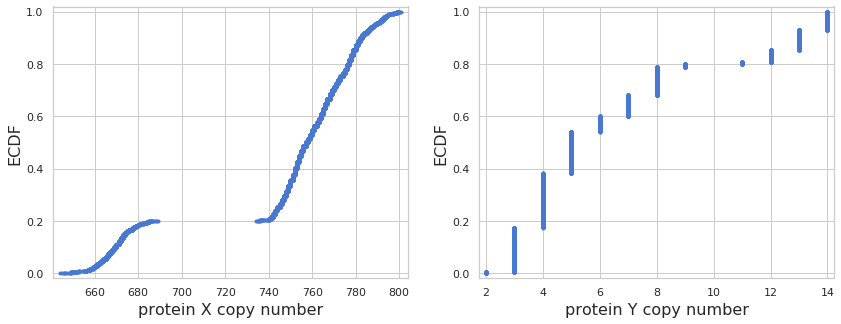

In [15]:
def ecdf(data):
    """Give x and y values for plotting ECDFs"""
    return np.sort(data), np.arange(1, len(data)+1) / len(data)

# Set up subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot histogram of mRNA profile with Poisson overlayed
x, y = ecdf(trajs_C[:,0,-1000:].flatten())
ax[0].plot(x, y, '.')
ax[0].set_xlabel('protein X copy number')
ax[0].set_ylabel('ECDF')
ax[0].margins(0.02)

# Plot histogram of protein profile
ax[1].plot(*ecdf(trajs_C[:,1,-1000:].flatten()), '.')
ax[1].set_xlabel('protein Y copy number')
ax[1].set_ylabel('ECDF')
ax[1].margins(0.02)